<a href="https://colab.research.google.com/github/C242-PS091-Capstone-Bangkit/ML-Project/blob/main/Skin%20Type/Skin_Type_Model_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1: Using CNN's with the Skin Type Dataset

For the first model we will use the `skin type` dataset to train a model that can classify 3 skin types. For this, we will create own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities. In addition, we also tried the pre-trained model from InceptionV3.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Required Libraries

Before we proceed with dataset, let's first install the required libraries to ensure everything is set up correctly for the next steps.

In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import ipywidgets as widgets
from io import BytesIO
from PIL import Image
from google.colab import files

Since we have already installed the required libraries, we can now proceed to the next step, which is **Pre-Processing the Dataset**.

<a name="2"></a>
## Pre-Processing the Dataset

Let's explore the dataset in the folder `./SkinCType`. There is a subdirectory for each skin type class, which consists of images representing various types, namely dry, normal, and oily. The complete directory tree looks like this:

```
.
└── SkinType/
    ├── Normal/
    │   ├── normal_1.jpg
    │   ├── normal_2.jpg
    │   └── ...
    └── Dry/
        ├── dry_1.jpg
        ├── dry_2.jpg
    |   └── ...
    └── Oily/
        ├── oily_1.jpg
        ├── oily_2.jpg
        └── ...

```

### Load Image

Before we begin building the model, let's load an image to explore it's content and understand it's properties. This will help us get a clearer idea of the data we're working with and ensure that we can process the images correctly for the next steps.

In [ ]:
DATA_DIR = '/content/drive/My Drive/Skin Type/Clean Data'

data_dir_normal = os.path.join(DATA_DIR, 'Normal')
data_dir_dry = os.path.join(DATA_DIR, 'Dry')
data_dir_oily = os.path.join(DATA_DIR, 'Oily')

print(f"There are {len(os.listdir(data_dir_normal))} images of normal skin type.")
print(f"There are {len(os.listdir(data_dir_dry))} images of dry skin type.")
print(f"There are {len(os.listdir(data_dir_oily))} images of oily skin type.")

There are 1080 images of normal skin type.
There are 946 images of dry skin type.
There are 1098 images of oily skin type.


While it's useful to know the number of images in each class, let's visualize a few of them to gain a clearer understanding of the types of images in the dataset:

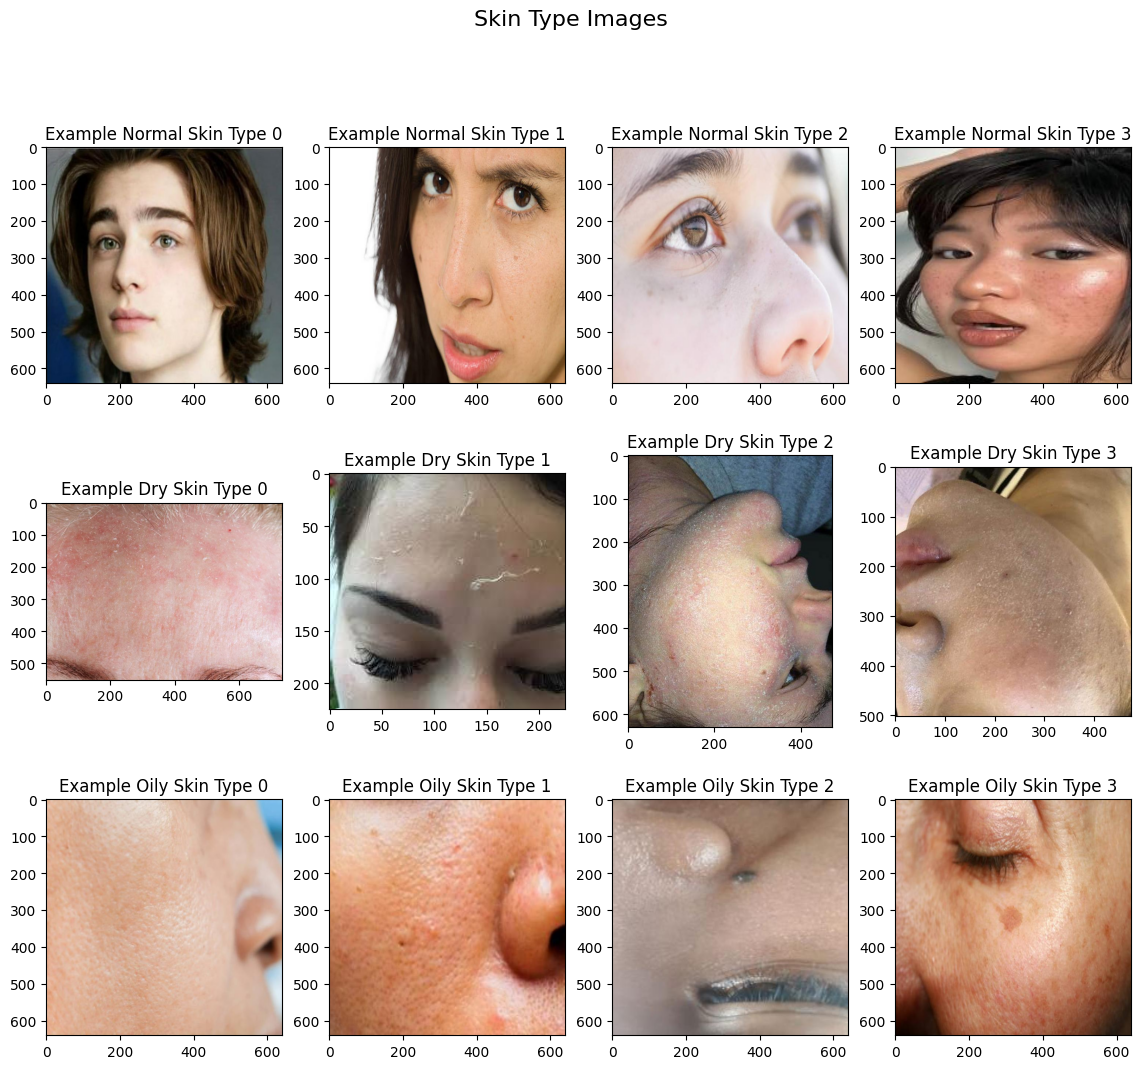

In [ ]:
normal_filenames = [os.path.join(data_dir_normal, filename) for filename in os.listdir(data_dir_normal)]
dry_filenames = [os.path.join(data_dir_dry, filename) for filename in os.listdir(data_dir_dry)]
oily_filenames = [os.path.join(data_dir_oily, filename) for filename in os.listdir(data_dir_oily)]

num_examples = 4

random_normal = random.sample(normal_filenames, num_examples)
random_dry = random.sample(dry_filenames, num_examples)
random_oily = random.sample(oily_filenames, num_examples)

fig, axes = plt.subplots(3, num_examples, figsize=(14, 12))
fig.suptitle('Skin Type Images', fontsize=16)

for i, normal_image in enumerate(random_normal):
    img = tf.keras.utils.load_img(normal_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Normal Skin Type {i}')

for i, dry_image in enumerate(random_dry):
    img = tf.keras.utils.load_img(dry_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dry Skin Type {i}')

for i, oily_image in enumerate(random_oily):
    img = tf.keras.utils.load_img(oily_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Oily Skin Type {i}')

plt.show()

These example images from each skin type class are certainly interesting! Notice that these images come in all kinds of resolutions!

### Split Dataset

Once we have loaded the images, the next step is to split the dataset into training and validation sets. This split ensures that we can train our model on one portion of the data while using another portion to evaluate its performance.

In [ ]:
def train_val_datasets():
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(224, 224),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='training',
        seed=42
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(224, 224),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='validation',
        seed=42
    )

    return training_dataset, validation_dataset

In [ ]:
training_dataset, validation_dataset = train_val_datasets()

Found 3124 files belonging to 3 classes.
Using 2500 files for training.
Found 3124 files belonging to 3 classes.
Using 624 files for validation.


At this point, we now have two separate datasets, one dedicated to training the model and the other for validating its performance.

The training dataset will be used to teach the model to recognize patterns and make predictions, while the validation dataset will allow we to assess how well the model generalizes to new, unseen data, helping to fine-tune the model and avoid overfitting.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_label_distribution(dataset):
    label_counts = {}
    for _, labels in dataset:
        unique_labels, counts = np.unique(np.argmax(labels.numpy(), axis=1), return_counts=True)
        for label, count in zip(unique_labels, counts):
            label_counts[label] = label_counts.get(label, 0) + count
    return label_counts

training_distribution = get_label_distribution(training_dataset)
validation_distribution = get_label_distribution(validation_dataset)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Label Distribution')

axes[0].bar(training_distribution.keys(), training_distribution.values())
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

axes[1].bar(validation_distribution.keys(), validation_distribution.values())
axes[1].set_title('Validation Dataset')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')

plt.show()

In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Keep in mind that the pixel values of the images are not normalized yet, so we need to add a Rescaling layer in the model to scale these values by a factor of 1./255.

### Data Augmentation

With the data in the approciate format, the next step is to apply data augmentation to enhance the model's robustness by creating varied image versions through transformations such as rotation, flipping, scaling, or color adjustments.

In [ ]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomContrast(0.1),
    ])
    return augmentation_model

augmentation_model = create_augmentation_model()
train_dataset = training_dataset.map(lambda x, y: (augmentation_model(x), y))

In [ ]:
def demo_augmentation(sample_image, model, num_aug):

    image_preview = []

    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    image_preview.append(sample_image_pil)

    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

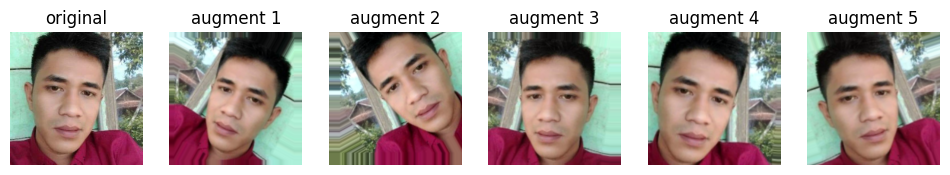

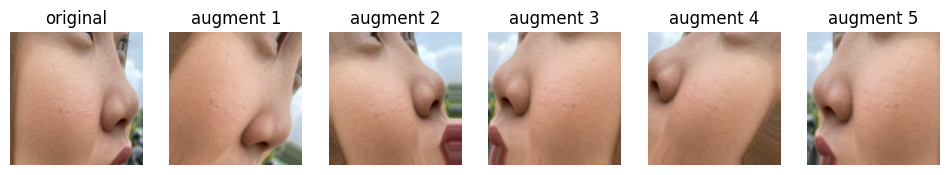

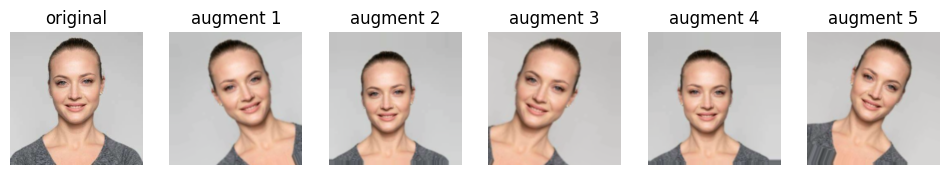

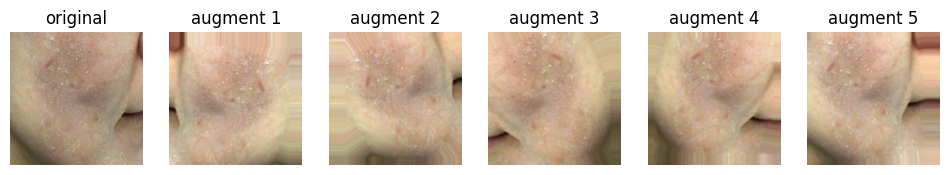

In [ ]:
NUM_AUG = 5

sample_batch = list(training_dataset.take(1))[0][0]

demo_augmentation(sample_batch[0], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[1], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[2], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[3], create_augmentation_model(), NUM_AUG)

del sample_batch

Now that we have applied data augmentation, the datasets with varied image versions are ready, and we can proceed to the next step, which is **Build and Train The Model**.

## Build and Train The Model

After completing the pre-processing steps, we will proceed by building the model using InceptionV3 and perform fine-tuning starting from layer 150 to adapt the model to our specific dataset.

In [ ]:
import tensorflow as tf

def create_transfer_learning_model():

    base_model = tf.keras.applications.InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(
        128, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    fine_tune_at = 150
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

The next cell allows us to examine the total number of parameters in the model.

In [ ]:
model = create_transfer_learning_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 17,629,635 (67.25 MB)

 Non-trainable params: 4,435,808 (16.92 MB)

Now, we can begin training the model. We will use 100 epochs for the training process.

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.5179 - loss: 3.4178 - val_accuracy: 0.7468 - val_loss: 2.9801
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8325 - loss: 2.7609 - val_accuracy: 0.8654 - val_loss: 2.6291
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9185 - loss: 2.4805 - val_accuracy: 0.9103 - val_loss: 2.5177
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9499 - loss: 2.3010 - val_accuracy: 0.8974 - val_loss: 2.4940
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9592 - loss: 2.1857 - val_accuracy: 0.9231 - val_loss: 2.2819
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9671 - loss: 2.0785 - val_accuracy: 0.9151 - val_loss: 2.2550
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9764 - loss: 1.9628 - val_accuracy: 0.9199 - val_loss: 2.1313
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9829 - loss: 1.8607 - val_accuracy: 0.9439 - 

The following code will display the training and validation accuracy achieved at the end of each epoch once the training is complete.

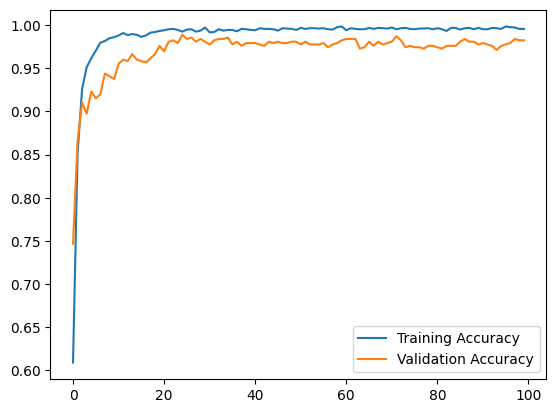

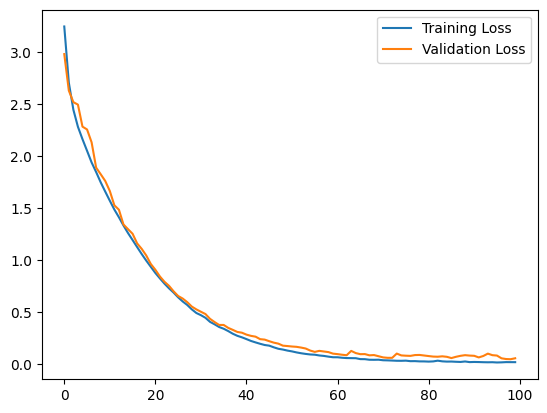

In [ ]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Now that we have successfully built and trained the model using the prepared dataset to achieve high accuracy, we can proceed to the next step, which is **Evaluate the Model**.

## Evaluate the Model

After training the model, we evaluate its performance using the confusion matrix. We can also view the Classification Report, which includes precision, recall, f1-score, and support for each class.

But, before creating the confusion matrix, we need to ensure that the labels are correctly assigned and match the predicted values with the actual ones.

In [ ]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(DATA_DIR, transform=transforms.ToTensor())
print(dataset.class_to_idx)

{'Dry': 0, 'Normal': 1, 'Oily': 2}


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step


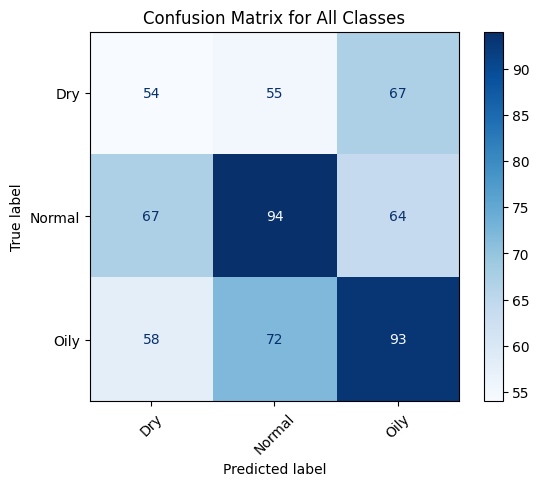

Classification Report:
              precision    recall  f1-score   support

         Dry       0.30      0.31      0.30       176
      Normal       0.43      0.42      0.42       225
        Oily       0.42      0.42      0.42       223

    accuracy                           0.39       624
   macro avg       0.38      0.38      0.38       624
weighted avg       0.39      0.39      0.39       624



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)

y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_class, y_pred_class)

class_labels = ['Dry', 'Normal', 'Oily']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix for All Classes")
plt.show()

print("Classification Report:")
print(classification_report(y_true_class, y_pred_class, target_names=class_labels))

The evaluation results show that the confusion matrix values are not very high, due to **various influencing factors**. However, despite the confusion matrix not being very high, the model can classify the skin type **sufficiently well** when tested.

After achieving satisfactory performance for classifying each skin type class, we can save the model using the following code.

In [ ]:
model.save('skin_type_model1.h5')
files.download('skin_type_model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We have completed all the steps and successfully built a model for skin type classification, saved in h5 format!